<a href="https://colab.research.google.com/github/ll3091/ANLY-590-02-Deep-Learning-Project/blob/master/DeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project: Aerial Image Classification

## Data Processing: Train Test Split

In [1]:
from google.colab import drive
! ls

gdrive	sample_data


In [0]:
# connect to Google drive
drive.mount('/content/gdrive/')

In [2]:
!ls gdrive/'My Drive'/DeepLearningProj

DeepLearningProject.ipynb  UCMerced_LandUse


In [3]:
# move to data directory, data source: http://weegee.vision.ucmerced.edu/datasets/landuse.html
% cd gdrive/'My Drive'/DeepLearningProj/UCMerced_LandUse

/content/gdrive/My Drive/DeepLearningProj/UCMerced_LandUse


In [0]:
# import libraries
import os
import shutil
import random as rand

In [5]:
# list files
os.listdir()

['Images',
 'readme.txt',
 'readme.txt.bak',
 'TrainSet',
 'TestSet',
 'VGGTransferLearning.h5']

In [6]:
# look at number of labels and images for each
imgsource = "./Images"
labels = os.listdir(imgsource)
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print(num_classes, ':', num_imgs)

21 : [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [7]:
# label names
print(labels)

['tenniscourt', 'parkinglot', 'mobilehomepark', 'overpass', 'sparseresidential', 'river', 'storagetanks', 'runway', 'freeway', 'intersection', 'chaparral', 'harbor', 'mediumresidential', 'forest', 'golfcourse', 'buildings', 'beach', 'agricultural', 'airplane', 'baseballdiamond', 'denseresidential']


In [8]:
# check if train/test split needs to be generated
trainpath = "./TrainSet"
testpath = "./TestSet"
split = input("Generate train/test split? (y/n)\t")
if split.lower()=='y':
  split_into_train_test = True
else:
  split_into_train_test = False

Generate train/test split? (y/n)	n


In [0]:
# ~ 15mins
# generate train/test split if 'y'
if split_into_train_test:
  # delete directories if they already exist
  if 'TrainSet' in os.listdir():
    ! rm -r TrainSet
  if 'TestSet' in os.listdir():
    ! rm -r TestSet
  # generate new folders
  os.makedirs(trainpath)
  os.makedirs(testpath)
  os.listdir()
  # for each label generate new folders
  for fold in labels:
    # randomly shuffle whether to copy image
    split = [True]*20+[False]*80
    rand.shuffle(split)
    img_files = os.listdir(imgsource+'/'+fold)
    os.makedirs(trainpath+'/'+fold)
    os.makedirs(testpath+'/'+fold)
    for f in img_files:
      if split.pop():
        shutil.copyfile(imgsource+'/'+fold+'/'+f, testpath+'/'+fold+'/'+f)
      else:
        shutil.copyfile(imgsource+'/'+fold+'/'+f, trainpath+'/'+fold+'/'+f)

In [10]:
# look at number of labels and images for each train/test set
imgsource = trainpath
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print('Training set\t', num_classes, 'classes :', num_imgs)

imgsource = testpath
num_classes = len(labels)
num_imgs = [len(os.listdir(imgsource+'/'+l)) for l in labels]
print('Test set\t', num_classes, 'classes :', num_imgs)

Training set	 21 classes : [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
Test set	 21 classes : [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


## Image Classification

In [11]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


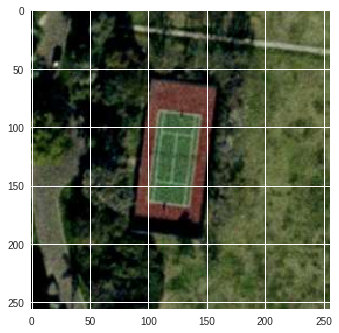

In [12]:
# display an image from training data
l = labels[0]
f = os.listdir('./TrainSet/'+l+'/')
plt.imshow(load_img('./TrainSet/'+l+'/'+f[0]))
plt.show()

### Image Generators

In [13]:
# build image generators for models
path_train_data = "./TrainSet/"
path_test_data = "./TestSet/"

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        path_train_data,
        classes = labels,
        target_size=(256, 256),
        batch_size=100,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        path_test_data,
        classes = labels,
        target_size=(256,256),
        batch_size=50,
        class_mode='categorical')

Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


### VGG16 Transfer Learning: Static

In [14]:
# build CNN with transfer learning using VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(256, activation="relu"))
model1.add(Dense(21, activation="sigmoid"))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [15]:
# fix base weights
conv_base.trainable = False
model1.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(32768, 256) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 21) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(21,) dtype=float32_ref>]

In [16]:
# check new number of trainable parameters
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 8,394,261
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# compile model
model1.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [18]:
# load model weights
#model.load_weights('VGGTransferLearning.h5')
# or
# train model
# ~15 minutes to run
transfer_learning_mod = model1.fit_generator(train_generator, steps_per_epoch=100, epochs=5, 
                                            validation_data=test_generator, validation_steps=25)
# save weights
model1.save_weights('VGGTransferLearning.h5')

Epoch 1/5
100/100 [==============================] - 236s 2s/step - loss: 0.9238 - acc: 0.7584 - val_loss: 0.4930 - val_acc: 0.8471
Epoch 2/5
100/100 [==============================] - 206s 2s/step - loss: 0.2240 - acc: 0.9448 - val_loss: 0.3734 - val_acc: 0.8741
Epoch 3/5
100/100 [==============================] - 213s 2s/step - loss: 0.0948 - acc: 0.9806 - val_loss: 0.2281 - val_acc: 0.9241
Epoch 4/5
100/100 [==============================] - 212s 2s/step - loss: 0.0526 - acc: 0.9900 - val_loss: 0.2681 - val_acc: 0.9207
Epoch 5/5
100/100 [==============================] - 211s 2s/step - loss: 0.0303 - acc: 0.9941 - val_loss: 0.4457 - val_acc: 0.8655


In [0]:
# function to plot performance
def plotModPerf(mod):
  acc = mod.history['acc']
  val_acc = mod.history['val_acc']
  loss = mod.history['loss']
  val_loss = mod.history['val_loss']

  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(15, 6))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = 'Training loss')
  plt.plot(epochs, val_loss, label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label = 'Training acc')
  plt.plot(epochs, val_acc, label = 'Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

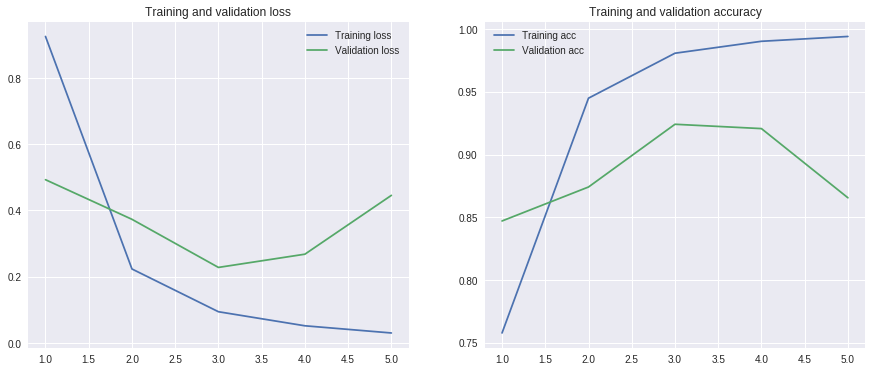

In [31]:
# function to plot performance
plotModPerf(transfer_learning_mod)

In [21]:
# look at labels of the test set
print(test_generator.class_indices)
class_labels = {}
# switch key and values for class labels
for k, v in test_generator.class_indices.items():
  class_labels[str(v)]=k
print(class_labels)

{'tenniscourt': 0, 'parkinglot': 1, 'mobilehomepark': 2, 'overpass': 3, 'sparseresidential': 4, 'river': 5, 'storagetanks': 6, 'runway': 7, 'freeway': 8, 'intersection': 9, 'chaparral': 10, 'harbor': 11, 'mediumresidential': 12, 'forest': 13, 'golfcourse': 14, 'buildings': 15, 'beach': 16, 'agricultural': 17, 'airplane': 18, 'baseballdiamond': 19, 'denseresidential': 20}
{'0': 'tenniscourt', '1': 'parkinglot', '2': 'mobilehomepark', '3': 'overpass', '4': 'sparseresidential', '5': 'river', '6': 'storagetanks', '7': 'runway', '8': 'freeway', '9': 'intersection', '10': 'chaparral', '11': 'harbor', '12': 'mediumresidential', '13': 'forest', '14': 'golfcourse', '15': 'buildings', '16': 'beach', '17': 'agricultural', '18': 'airplane', '19': 'baseballdiamond', '20': 'denseresidential'}


In [0]:
# build functions to look at misclassifications
def display(misclass):
  plt.figure(figsize=(15, 10))

  n = int(np.ceil(np.sqrt(len(misclass))))
  ind = 1
  for y, yhat, x in misclass:
    plt.subplot(n, n, ind)  
    plt.grid(False)
    plt.axis('off')
    plt.text(.5, .5, y+'->\n'+yhat, fontsize=9, color='red')
    plt.imshow(x)
    ind +=1
  plt.show()

def eval_model(model, img_gen):
  
  ind = 1
  
  misclass = []
  
  for i in range(len(img_gen)):
    xs, ys = img_gen.next()
    ys = [class_labels[str(np.argmax(l))]  for l in ys]
    yhats = model.predict(xs)
    yhats = [class_labels[str(np.argmax(p))] for p in yhats]
    
    for y, yhat, x in (list(zip(ys, yhats, xs))):
      if y != yhat:
        misclass.append((y, yhat, x))
  display(misclass)
  misclass = [y+'->'+yhat for y, yhat, x in misclass]
  [print(cnt) for cnt in Counter(misclass).most_common()]

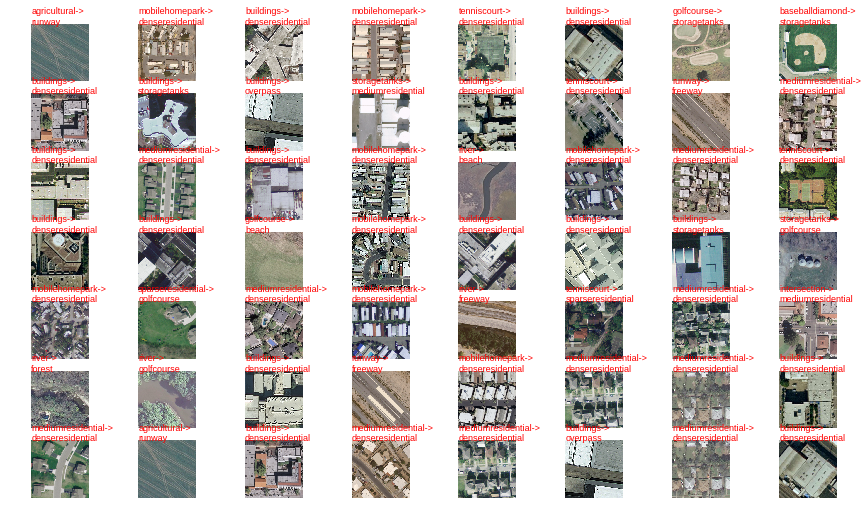

('buildings->denseresidential', 14)
('mediumresidential->denseresidential', 11)
('mobilehomepark->denseresidential', 8)
('tenniscourt->denseresidential', 3)
('agricultural->runway', 2)
('buildings->storagetanks', 2)
('buildings->overpass', 2)
('runway->freeway', 2)
('golfcourse->storagetanks', 1)
('baseballdiamond->storagetanks', 1)
('storagetanks->mediumresidential', 1)
('river->beach', 1)
('golfcourse->beach', 1)
('storagetanks->golfcourse', 1)
('sparseresidential->golfcourse', 1)
('river->freeway', 1)
('tenniscourt->sparseresidential', 1)
('intersection->mediumresidential', 1)
('river->forest', 1)
('river->golfcourse', 1)


In [23]:
# look at misclassifications
eval_model(model1, test_generator)

In [0]:
del model1

### VGG16 Transfer Learning: Non-Static

In [32]:
# build another CNN with transfer learning using VGG16
model2 = Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dense(21, activation="sigmoid"))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_6 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [33]:
# have static base weights
conv_base.trainable = True
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_6 (Dense)              (None, 21)                5397      
Total params: 23,108,949
Trainable params: 23,108,949
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile model
model2.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [35]:
# load model weights
# model2.load_weights('VGGTransferLearning2.h5')
# or
# train model
# ~30 minutes to run
transfer_learning_mod2 = model2.fit_generator(train_generator, steps_per_epoch=100, epochs=5, 
                                            validation_data=test_generator, validation_steps=25)
# save weights
model2.save_weights('VGGTransferLearning2.h5')

Epoch 1/5
100/100 [==============================] - 387s 4s/step - loss: 2.3877 - acc: 0.2563 - val_loss: 1.4936 - val_acc: 0.4828
Epoch 2/5
100/100 [==============================] - 384s 4s/step - loss: 0.9724 - acc: 0.6836 - val_loss: 0.5277 - val_acc: 0.8092
Epoch 3/5
100/100 [==============================] - 384s 4s/step - loss: 0.4453 - acc: 0.8633 - val_loss: 0.4989 - val_acc: 0.8448
Epoch 4/5
100/100 [==============================] - 384s 4s/step - loss: 0.2630 - acc: 0.9201 - val_loss: 0.4814 - val_acc: 0.8578
Epoch 5/5
100/100 [==============================] - 385s 4s/step - loss: 0.2275 - acc: 0.9390 - val_loss: 0.3680 - val_acc: 0.8897


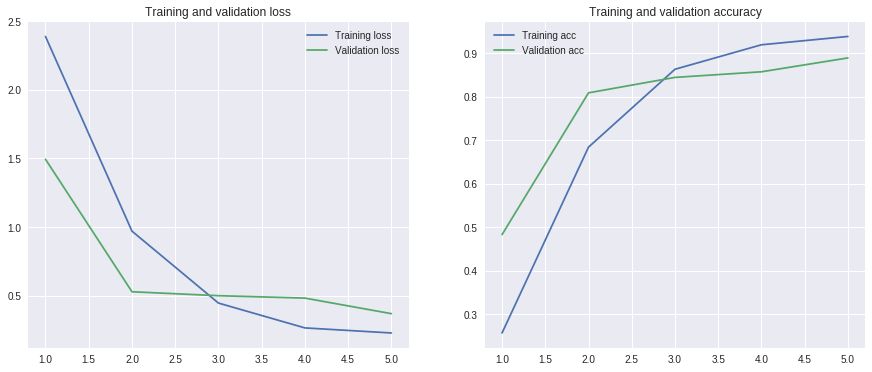

In [36]:
# plot performance
plotModPerf(transfer_learning_mod2)

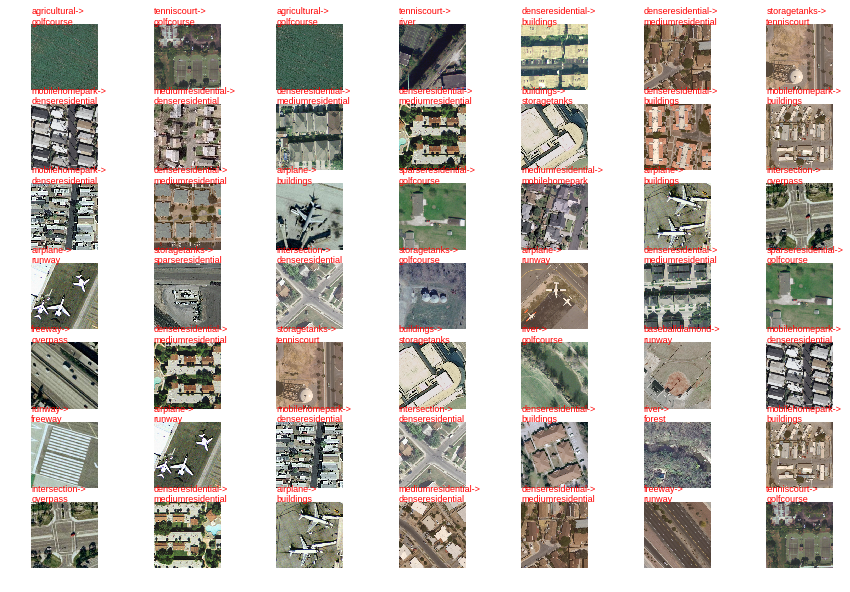

('denseresidential->mediumresidential', 8)
('mobilehomepark->denseresidential', 4)
('denseresidential->buildings', 3)
('airplane->buildings', 3)
('airplane->runway', 3)
('agricultural->golfcourse', 2)
('tenniscourt->golfcourse', 2)
('storagetanks->tenniscourt', 2)
('mediumresidential->denseresidential', 2)
('buildings->storagetanks', 2)
('mobilehomepark->buildings', 2)
('sparseresidential->golfcourse', 2)
('intersection->overpass', 2)
('intersection->denseresidential', 2)
('tenniscourt->river', 1)
('mediumresidential->mobilehomepark', 1)
('storagetanks->sparseresidential', 1)
('storagetanks->golfcourse', 1)
('freeway->overpass', 1)
('river->golfcourse', 1)
('baseballdiamond->runway', 1)
('runway->freeway', 1)
('river->forest', 1)
('freeway->runway', 1)


In [37]:
# look at misclassifications
eval_model(model2, test_generator)

In [0]:
del model2

### Fully Trained CNN

In [39]:
# build a CNN from scratch without transfer learning
model3 = Sequential()
model3.add(Conv2D(filters = 32, kernel_size=(2, 2), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(256, 256, 3)))
model3.add(Conv2D(filters = 32, kernel_size=(4, 4), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))
model3.add(MaxPooling2D(pool_size=(5,5)))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(21, activation='softmax'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               20480256  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [0]:
# compile model
model3.compile(loss="categorical_crossentropy", optimizer=RMSprop(1e-4), metrics=["acc"])

In [0]:
# load model weights
# model3.load_weights('CNNmod3.h5')
# or
# ~2 hours to run
training_mod = model3.fit_generator(train_generator, steps_per_epoch=100, epochs=50, 
                                            validation_data=test_generator, validation_steps=25)
# save weights
model3.save_weights('CNNmod3.h5')

Epoch 1/50
100/100 [==============================] - 192s 2s/step - loss: 2.8578 - acc: 0.1443 - val_loss: 2.5976 - val_acc: 0.2241
Epoch 2/50
100/100 [==============================] - 189s 2s/step - loss: 2.5331 - acc: 0.2430 - val_loss: 2.3048 - val_acc: 0.3397
Epoch 3/50
100/100 [==============================] - 189s 2s/step - loss: 2.2906 - acc: 0.3191 - val_loss: 2.1426 - val_acc: 0.3824
Epoch 4/50
100/100 [==============================] - 186s 2s/step - loss: 2.1060 - acc: 0.3674 - val_loss: 1.9705 - val_acc: 0.4716
Epoch 5/50
100/100 [==============================] - 186s 2s/step - loss: 1.9260 - acc: 0.4203 - val_loss: 1.9155 - val_acc: 0.4543
Epoch 6/50
100/100 [==============================] - 186s 2s/step - loss: 1.7892 - acc: 0.4613 - val_loss: 1.7564 - val_acc: 0.4836
Epoch 7/50
100/100 [==============================] - 187s 2s/step - loss: 1.6713 - acc: 0.4940 - val_loss: 1.6212 - val_acc: 0.5403
Epoch 8/50
100/100 [==============================] - 185s 2s/step - 

In [0]:
# plot performance
plotModPerf(training_mod)

In [0]:
# look at misclassifications
eval_model(model3, test_generator)